# Best Actor - Mobile Game about Facial Expression based on Convolutional Neural Network

## Abstract

TODO

## Terminology

TODO

## UI & UX Design

TODO

## Technical Design

TODO

## Code Implementation

### Part 1: Computer Vision

#### **Preprocess Data**

First and foremost, we need to preprocess the dataset. Here I use **FER2013** dataset for the facial expression recognition, which contains 7 categories in total, including (1) Angry, (2) Disgust, (3) Fear, (4) Happy, (5) Neutral, (6) Sad and (7) Surprise. The examples of FER2013 dataset are illustrated as follows.

![Facial Expressions](https://drive.google.com/uc?id=11VQZQZLD0_GwkcR4vUWTNtBdbbZS0Dh7)

The dataset has the following advantages:
- It contains dataset with various ages
![age](https://drive.google.com/uc?id=1mUcafNru8bb6pn-6xFkW74qIQVpI9Jyh)
- It contains dataset with different ethics
![ethic](https://drive.google.com/uc?id=1bZf1BR-fVZvnHmlgT-ZDbJKRQULxfOJ7)
- It contains dataset with accessories
![accessory](https://drive.google.com/uc?id=1xmEbRDzKBeDRpGa63hGH-kIBOGMXMJJp)

However, the dataset also has the following disadvantages:
- Some images have watermark, which might have potential copyright issue
![watermark](https://drive.google.com/uc?id=142nfQZ3a1hMdFhQIr2-V3wmxBEvYFDhz)
- Some images are cartoon characters
![cartoon](https://drive.google.com/uc?id=1UTUDU5ac8aTcfR9O7WTqDUkGgj-1RfkJ)
- Some images have inconsistent facial expressions and labels. For example, the following facial expressions are marked as "Happy" in FER2013 dataset, which are apparently not "Happy" facial expressions
![inconsistent](https://drive.google.com/uc?id=1Gu0SNL7B3uoQ7TEmv1LRe3-97NCET9iX)
- Some images are broken and have no facial expressions
![non-people](https://drive.google.com/uc?id=1sbeWG41IOot29GOY6iCAwRQPG71-Euhk)
- Some images have multiple faces
![many](https://drive.google.com/uc?id=1l8PPTBHb7BPS7LukOAdVV0yM1ZaBSAlQ)

Therefore, I preprocessed the dataset by removing ineligible images. Then, I created the preprocessed "train.csv" with the following function.
```python
from PIL import Image
import os
import imghdr
import numpy
import csv

# Constants
TRAINING_DATA_DIRECTORY = 'TrainingDataSelected/'
TRAIN_CSV_FILE = 'train.csv'
TRAIN_CSV_WRITE_MODE = 'w'
TRAIN_DATA_IMAGE_TYPE = 'jpeg'

FACIAL_EXPRESSION_LABELS = {
    'Happy': '0',
    'Sad': '1',
    'Surprise': '2'
}

class Preprocessor:

    def preprocess_data(self):
        """Preprocess facial expression dataset.
        This function will save training data to train.csv in the directory.
        train.csv contains two columns:
        - Facial expression label
        - Numpy array of facial expression image file (48 x 48)
        """
        with open(TRAIN_CSV_FILE, mode=TRAIN_CSV_WRITE_MODE) as train:

            # Create train writer
            train_writer = csv.writer(train)

            # Iterate through training image data
            with os.scandir(TRAINING_DATA_DIRECTORY) as entries:

                for entry in entries:
                    path = entry.path
                    file_type = imghdr.what(path)

                    if file_type == TRAIN_DATA_IMAGE_TYPE:

                        # Label
                        name = entry.name
                        facial_expression_name = name.split('_')[0]
                        label = FACIAL_EXPRESSION_LABELS[facial_expression_name]

                        # Image file
                        image_file = Image.open(path)
                        image = numpy.array(image_file)
                        pixels = '-'.join(map(str, image.flat))

                        # Write to CSV file
                        row = [label, pixels]
                        train_writer.writerow(row)

# Preprocess data
preprocessor = Preprocessor()
preprocessor.preprocess_data()
```

#### **Load Data**

After preprocessed the data, the "train.csv" has been uploaded to Google Drive. Then, use the following function to download the dataset.

In [1]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1nN7LOW50ZpLAJ7tb6w6_OuOgpWv1rOV1' -O train.csv

--2020-01-26 03:34:02--  https://docs.google.com/uc?export=download&id=1nN7LOW50ZpLAJ7tb6w6_OuOgpWv1rOV1
Resolving docs.google.com (docs.google.com)... 172.217.212.101, 172.217.212.139, 172.217.212.100, ...
Connecting to docs.google.com (docs.google.com)|172.217.212.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-34-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nk0q99prt5bog7gibotttblcg69iej73/1580004000000/05684750869889568925/*/1nN7LOW50ZpLAJ7tb6w6_OuOgpWv1rOV1?e=download [following]
--2020-01-26 03:34:06--  https://doc-00-34-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nk0q99prt5bog7gibotttblcg69iej73/1580004000000/05684750869889568925/*/1nN7LOW50ZpLAJ7tb6w6_OuOgpWv1rOV1?e=download
Resolving doc-00-34-docs.googleusercontent.com (doc-00-34-docs.googleusercontent.com)... 173.194.193.132, 2607:f8b0:4001:c0f::84
Connecting to doc-00-34-docs.googleusercontent.com (doc-00

Here, we need to load the dataset with the following function.

In [0]:
import csv
import numpy

# Constants
TRAIN_DATA_FILE = 'train.csv'

class DataLoader:

    def load_train_data(self):
        """Load train dataset.
        This function will create numpy array of train images and labels.
        """
        images = []
        labels = []

        # Open train.csv file
        with open(TRAIN_DATA_FILE) as train_csv:

            # Read train.csv file
            csv_reader = csv.reader(train_csv)
            for row in csv_reader:

                pixels_str = row[1]
                pixels_list = [int(i) for i in pixels_str.split('-')]
                pixels_list = numpy.array(pixels_list, dtype='uint8')
                image = pixels_list.reshape((48, 48))

                label = int(row[0])

                images.append(image)
                labels.append(label)

        # Create numpy array of train images and labels
        x_train = numpy.array(images)
        y_train = numpy.array(labels)

        return (x_train, y_train)

Then, load the train data, and show some images.

In [0]:
# Load data
data_loader = DataLoader()
x_train, y_train = data_loader.load_train_data()

x_train shape: (9000, 48, 48)
y_train shape: (9000,)
Label is: 0


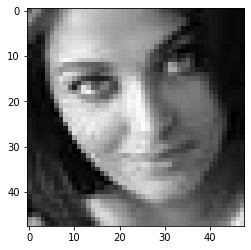

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

print('x_train shape: {0}'.format(x_train.shape))
print('y_train shape: {0}'.format(y_train.shape))

image = x_train[0]
label = y_train[0]

print('Label is: ' + str(label))
plt.imshow(image, cmap='gray')

#### **Tune Hyperparameter**

TODO

#### **Train Data**

TODO

#### **Evaluate Model**

TODO

#### **Export Model**

TODO

#### **Convert CoreML Model**

TODO

### Part 2: Mobile Game

#### **Crop ROI with OpenCV**

TODO

#### **Predict using CoreML Model**

TODO

## Video Demonstration

TODO

## Conclusion

TODO

## Reference

TODO